# A Defender Rating System Based On Learned Positive And Negative Route Support Vectors

###### The problem I am attempting to solve in this notebook is how to give a general rating to a defensive player based on their performance in a given play. My specific approach takes inspiration from applications of a support vector machine (svm) splitting a dataset of two dimensions. If we consider a space with numerous object which we wish to maneuver around, a solution through these objects resembles the classification of two sets of data, one on each side of the chosen path. 

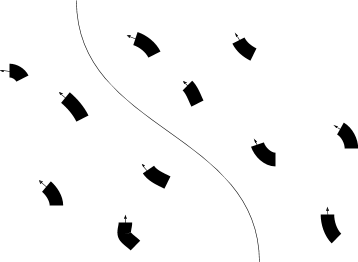

###### Now if we take another step in the direction of a traditional svm, we can assign a class to each of the two sets of objects split by our path. We extend the path to produce two support vectors modeling the the furthest extremes in which the path can shift in either direction while still correctly splitting the data according to the path**, it would look something like this. 

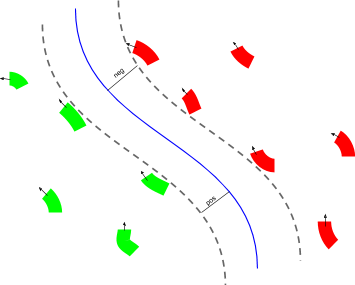

###### If this route was imagined to be the route of a defender, they would be following or attempting to predict the route of a receiver. This receiver must be on one side of the defender path, therefore we label the support vectors as positive and negative. We assume that being closer to the receiver during the route forces a more optimal outcome for the defender (an incomplete pass). Replacing the two dimensional data with data more closely aligned with the problem at hand, we end up with the figure below. While the data points are not relevent, we decide our path based on a general learned model of route decisions throughout the play.

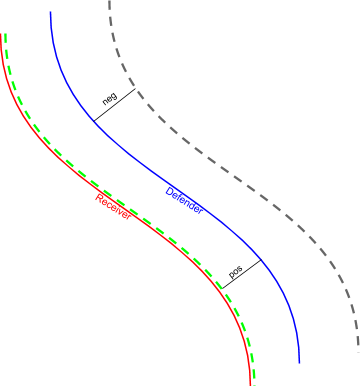

###### Therefore a defender can be evaluated based on their tendencies to stray closer to the positive or negative path prediction. 

## Extracting Data

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import seaborn as sns
import os
from pathlib import Path
import collections


"""
Possible Events
['None' 'ball_snap' 'pass_forward' 'pass_arrived' 'pass_outcome_caught'
 'first_contact' 'out_of_bounds' 'line_set' 'tackle' 'play_action'
 'touchdown' 'pass_outcome_incomplete' 'pass_tipped'
 'pass_outcome_touchdown' 'fumble' 'fumble_offense_recovered' 'qb_sack'
 'fumble_defense_recovered']

"""
start_of_pass_event = np.array(['pass_forward', 'pass_shovel'])
end_of_pass_event = np.array(['pass_outcome_incomplete', 'pass_outcome_caught', 'pass_outcome_touchdown'])
skip_plays_where = np.array(['qb_sack','qb_strip_sack','pass_outcome_interception'])
usable_defense_attributes = ['x','y','r','dir','s','a']


# ===============
weeks = [pd.read_csv(f"../input/nfl-big-data-bowl-2021/week{i}.csv") for i in range(1,18)]
weeks_df = pd.concat(weeks,axis=0)
# ===============
# weeks_df = pd.read_csv("../input/nfl-big-data-bowl-2021/week1.csv")
# ===============

plays_df = pd.read_csv('../input/nfl-big-data-bowl-2021/plays.csv')

def dist(player1, player2):
    return np.sqrt((player1[0] - player2[0])**2 + (player1[1] - player2[1])**2)

# given a play slice, find which player is closest to the football at the throw frame 
def get_passer(play_slice, offense_team):
    throw_frame = play_slice[(play_slice.event.isin(start_of_pass_event)) & (play_slice.team == offense_team)]
    football = play_slice[(play_slice.event.isin(start_of_pass_event)) & (play_slice.team == 'football')]
    passer = throw_frame.iloc[((throw_frame['x']-football['x'].values)**2 + (throw_frame['y']-football['y'].values)**2).argsort()[:1]]
    try:
        assert(len(passer) == 1)
    except:
        print(play_slice.event.unique())
        assert(len(passer) == 1) # force error 
    return passer
    
# given a play slice, find which player is closest to the football at the catch frame 
def get_receiver(play_slice, offense_team):
    catch_frame = play_slice[(play_slice.event.isin(end_of_pass_event)) & (play_slice.team == offense_team)]
    football = play_slice[(play_slice.event.isin(end_of_pass_event)) & (play_slice.team == 'football')]
    receiver = catch_frame.iloc[((catch_frame['x']-football['x'].values)**2 + (catch_frame['y']-football['y'].values)**2).argsort()[:1]]
    try:
        assert(len(receiver) == 1)
    except:
        print(play_slice.event.unique())
        print(len(receiver))
        assert(len(receiver) == 1) # force error
    return receiver

def sort_by_distance_to(players, target):
    
    try:
        dists = np.sqrt((players['x']-target['x'].values)**2 + (players['y']-target['y'].values)**2)
    except:
        print(players.shape,target.shape)
        assert(False)
    
    players = pd.concat([players, pd.DataFrame({'r' : dists})], axis=1, sort=False) # store distances to receiver
    sorted_args = dists.argsort()
    sorted_players = players.iloc[sorted_args]
    return sorted_players

def store_play_info(week_df, dictionary={}, player_dictionary={}):
    data = []
    max_row_len = 0
    play_info_dict = {}
    skipped = []
    total = 0    
    games = week_df.gameId.unique() # gameId are the only globally unique identifier
    print("Gathering Data...")
    for gameId in games:
        game_slice = week_df[week_df.gameId == gameId]
        plays = game_slice.playId.unique() # playId is unique within the scope of each game
        for playId in plays:
            total+=1
            
            play_slice = game_slice[game_slice.playId == playId]      
            
            # if one of these specific events, skip play
            e = [reason in play_slice.event.values for reason in skip_plays_where]
            if(any(e)):
                skipped += skip_plays_where[e].tolist()
                continue
                
            # if these start of pass events do not happen, skip play
            e = [reason in play_slice.event.values for reason in start_of_pass_event]
            if(not any(e)):
                skipped += start_of_pass_event[e].tolist()
                continue
                
            # if these end of pass events do not happen, skip play
            e = [reason in play_slice.event.values for reason in end_of_pass_event]
            if(not any(e)):
                skipped += end_of_pass_event[e].tolist()
                continue
            
            # figure out which team is on offense during this play
            offense_team = play_slice[play_slice.position == 'QB'].team
            # error in data, skip this one play
            if(len(offense_team) == 0):
                continue
            offense_team = offense_team.values[0]
            defense_team = 'away' if offense_team == 'home' else 'home'
            
            # identify passer and receiver 
            try:
                passer = get_passer(play_slice, offense_team = offense_team)
                receiver = get_receiver(play_slice, offense_team=offense_team)
            except:
                skipped += ['unknown']
                continue
                
            play = plays_df.query('gameId == @gameId and playId == @playId') # check if the passer and receiver are correct by getting play desc
            
#             # ===================================================
#             # proof passer and receiver works
#             print(f'Info Extract: pass from {passer.displayName.item()} to {receiver.displayName.item()} was {play.passResult.item()}')
#             print('Official Desc:',play.playDescription.item())
#             # ===================================================
        
            # time of throw and catch as integers
            throw_frame_int = passer.frameId.values[0]
            catch_frame_int = receiver.frameId.values[0]
            ball_snap_int = play_slice[play_slice.event=='ball_snap'].iloc[0].frameId.item()
            
            football_at_throw = play_slice[(play_slice.frameId == throw_frame_int) & (play_slice.team == 'football')]
            receiver_at_throw = play_slice[(play_slice.frameId == throw_frame_int) & (play_slice.nflId == receiver.nflId.item())]
            defense_at_throw = play_slice[(play_slice.frameId == throw_frame_int) & (play_slice.team == defense_team)]
            
            # skip problematic plays
            if(len(receiver_at_throw)!=1):
                continue
            if(len(defense_at_throw)==0):
                continue
                
            defense_sorted = sort_by_distance_to(defense_at_throw,receiver_at_throw)
            
            
            
            
#             # ===================================================
#             # proof sort of defense distances worked
#             x,y = receiver_at_throw[['x','y']].values[0]
#             for coord in defense_sorted[['x','y']].values:
#                 print(dist((x,y),coord))
#             # ===================================================
            
    
            play_completion = plays_df[(plays_df['gameId'] == gameId) & (plays_df['playId'] == playId)]['passResult']
            play_r = play_slice[play_slice.nflId == receiver.nflId.item()][['x','y','s','a','dis','o','dir']]
            play_d = play_slice[play_slice.nflId == defense_sorted.iloc[0].nflId.item()][['x','y','s','a','dis','o','dir','time','frameId','gameId','playId']]
            columns = np.hstack(([f'r_{c}' for c in play_r.columns],[f'd_{c}' for c in play_d.columns[:7]],play_d.columns[7:]))
            
            # somehow one is not labeled in the last frame
            if(len(play_r)!=len(play_d)):
                length = min(len(play_r),len(play_d))
                play_r = play_r.iloc[:length]
                play_d = play_d.iloc[:length]
#                 print(play_slice[(play_slice.nflId == receiver.nflId.item()) | (play_slice.nflId == defense_sorted.iloc[0].nflId.item())][['nflId','frameId']])
                
                
                
            play_limited = np.hstack((play_r.values,play_d.values))
            play_limited = pd.DataFrame(play_limited,columns = columns)
            
            # calculate the angle in between the direction the defender is traveling and the direction the receiver is traveling 
            dirs = (play_limited[['d_dir']] * np.pi/180) + np.pi/2
            w = (play_limited[['r_y']].values - play_limited[['d_y']]).values.tolist()
            s = (play_limited[['r_x']].values - play_limited[['d_x']]).values.tolist()
            optimal_angle = np.arctan2(w,s)
            angle_between = np.abs(optimal_angle - (dirs.values))
            angle_between = pd.DataFrame(np.where(angle_between>np.pi, 2*np.pi - angle_between, angle_between),columns=['angle_between'])            
            play_limited = pd.concat([play_limited,angle_between],axis=1)
        
            if(gameId not in dictionary):
                dictionary[gameId] = {}
            dictionary[gameId][playId] = {
                'play_slice' : play_limited,
                'play_completion' : play_completion.item(),
                'throw_frame_int' : throw_frame_int,
                'catch_frame_int' : catch_frame_int,
                'ball_snap_int' : ball_snap_int,
                
            }
            
            
            d_nflId = defense_sorted.iloc[0].nflId.item()
            if(d_nflId not in player_dictionary):
                player_dictionary[d_nflId] = []
            player_dictionary[d_nflId].append({
                'gameId' : gameId,
                'playId' : playId,
                
                'receiver_nflId' : receiver.nflId.item(),
                'receiver_name' : receiver.displayName.item(),
                'receiver_data' : play_slice[play_slice.nflId == receiver.nflId.item()][['x','y','s','a','dis','o','dir']],
                
                'defender_name' : defense_sorted.iloc[0].displayName,
                'defender_data' : play_slice[play_slice.nflId == d_nflId][['x','y','s','a','dis','o','dir']],
                
            
            })           
                    

            
#             break
#         break
            
            
    
#     for i in range(len(data)):
#         data[i] = data[i][:-1]+([np.nan]*(max_row_len-len(data[i])))+[data[i][-1]]
#     data = np.array(data)
    
    
    return np.array(sorted(skipped,reverse=True)), total, data, dictionary, player_dictionary
    
            
# for i,week in enumerate(weeks):
#     print(f'week {i+1}')
#     skipped, total, data, plays_dict, player_dict = store_play_info(week)
skipped, total, data, plays_dict, player_dict = store_play_info(weeks_df)

# print(player_dict)

In [ ]:
# gather extracted data into datasets and split/scale

# each frame is 1/10 of a second, so t-2 for reaction time of 0.2 seconds

X = []
y = []

X_neg = []
y_neg = []

attributes = ['x','y','s','a','dir']

time = []
for gkey in plays_dict.keys():
    for pkey in plays_dict[gkey].keys():        
        catch_frame_int = plays_dict[gkey][pkey]['catch_frame_int']
        ball_snap_int = plays_dict[gkey][pkey]['ball_snap_int']
        completion = plays_dict[gkey][pkey]['play_completion']
        total_time = catch_frame_int - ball_snap_int
        play_slice = plays_dict[gkey][pkey]['play_slice']
        
        time.append(total_time)
        play_slice = play_slice[(play_slice.frameId > ball_snap_int) & (play_slice.frameId < catch_frame_int)]
        x_array = np.hstack((play_slice[[f'd_{a}' for a in attributes]].values[:-2],
                                  play_slice[[f'r_{a}' for a in attributes]].values[2:]))
        y_array = play_slice[[f'd_{a}' for a in attributes]].values[2:]

        if(completion == 'I'):
            # what the defense should do
            X.append(x_array)
            y.append(y_array)
            
        else:
            # what the defense should not do
            X_neg.append(x_array)
            y_neg.append(y_array)
            
    
    
    
X = np.vstack(X)
y = np.vstack(y)
X_neg = np.vstack(X_neg)
y_neg = np.vstack(y_neg)


## Rating Defense On Learned General Optimal Route

###### Using a random forest regressor, we can learn the behavior exhibited in plays and build a model predicting the movements of a defender. For every timeframe in the play, we use the defenders current attributes along side the attributes of a receiver 0.2 seconds earlier in the play. This is to account for a typical human reaction time. At each timeframe, the next movement is then predicted from both models. 

In [ ]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor

def find_scaler(X_train):
    max_data = np.max(X_train,axis=0)
    return max_data + max_data * 0.1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=4)

X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(
    X_neg, y_neg, test_size=0.3, random_state=4)


# scale the data between 0 and 1
scaler = find_scaler(X_train)
y_scaler = scaler[:len(scaler)//2]
X_train = X_train/scaler
y_train = y_train/y_scaler
X_test = X_test/scaler
y_test = y_test/y_scaler

scaler_neg = find_scaler(X_train_neg)
y_scaler_neg = scaler_neg[:len(scaler_neg)//2]
X_train_neg = X_train_neg/scaler_neg
y_train_neg = y_train_neg/y_scaler_neg
X_test_neg = X_test_neg/scaler_neg
y_test_neg = y_test_neg/y_scaler_neg



max_depth = 30

print('fitting pos')
regr_rf = RandomForestRegressor(n_estimators=100, max_depth=max_depth, random_state=2)
regr_rf.fit(X_train, y_train)
y_rf = regr_rf.predict(X_test)
print(f"RF Accuracy Score={regr_rf.score(X_test, y_test):.2f}")

print('fitting neg')
regr_rf_neg = RandomForestRegressor(n_estimators=100, max_depth=max_depth, random_state=2)
regr_rf_neg.fit(X_train_neg, y_train_neg)
y_rf_neg = regr_rf_neg.predict(X_test_neg)
print(f"RF Accuracy Score={regr_rf_neg.score(X_test_neg, y_test_neg):.2f}")




In [ ]:
print(f"Testing the pass completed data to positive model={regr_rf.score(X_test_neg, y_test_neg):.2f}")
print(f"Testing the pass incomplete data to negative model={regr_rf_neg.score(X_test, y_test):.2f}")


y_pos_pred_neg = regr_rf.predict(X_test_neg)
y_neg_pred_pos = regr_rf_neg.predict(X_test)

# print('Defender:')
# print(X_test[0,X_test.shape[1]//2:])
# print('Receiver:')
# print(X_test[0,:X_test.shape[1]//2])
# print('Pos Prediction:')
# print(y_rf[0])
# print('Neg Prediction:')
# print(y_neg_pred_pos[0])

example = 0

df = pd.DataFrame(np.vstack((X_test[example,X_test.shape[1]//2:],X_test[example,:X_test.shape[1]//2],y_rf[example],y_neg_pred_pos[example])),columns=attributes,index=['D','R','pos pred','neg pred'])
df.iloc[0] = df.iloc[0]*scaler[:len(scaler)//2]
df.iloc[1] = df.iloc[1]*scaler[len(scaler)//2:]
df.iloc[2] = df.iloc[2]*y_scaler
df.iloc[3] = df.iloc[3]*y_scaler_neg
df
    


###### Above we see the accuracy scores for both models. In the first block we see a positive model accuracy of 93%, and a negative model accuracy of 91%. This is, of course a regressive solution and therefore accuracy here is just an R^2 metric. In the second block we see a difference when passing complete pass data to the positive model, as well as relatively similar drop when passing incomplete pass data to the negative model. This implies a fundamental difference in defender movement behavior dictating whether a pass results in being complete or incomplete, and that this difference can be learned.

###### In the example data shown above, we see a single timeframe of a defender, and the timeframe 0.2 seconds earlier of a receiver to account for reaction time. The positive model shows the predicted next position of the defender to be closer to the receiver, with speed, acceleration, and direction also making minor adjustments to be more similar to the receiver. This is what one would expect, but this serves as a confirmation of hypothesis. The negative model shows similar characteristics in some cases, but it appears somewhat more unintuitive. 

##### Below is the fully defined scoring model, and a few visuals to support it. The final score of a defender is defined as the similarity of the defenders route to the two predicted by each of the positive and negative models. S = P/N-1, where P and R are the average distances between the each of the respective models and the defenders path. Overall values above 0 represent plays that more closely resemble a positive general performance, and those below 0 represent plays that resemble poor defensive performance. 

In [ ]:
def moving_avg(x,n=10):
    return np.convolve(x,np.ones(n)/n,mode='valid')

def moving_avg_2d(x, y, n=10):
    mavg_x = np.convolve(x,np.ones(n)/n,mode='valid')
    mavg_y = np.convolve(y,np.ones(n)/n,mode='valid')
    return mavg_x, mavg_y

def plot_moving_avg(x,y,n=10,label='',c=None):
    mavg_x = np.convolve(x,np.ones(n)/n,mode='valid')
    mavg_y = np.convolve(y,np.ones(n)/n,mode='valid')
    plt.plot(mavg_x,mavg_y,label=label,c=c)

def score_defender(pos_model, neg_model, play, show=False):
    d_data = play['defender_data'][attributes]
    r_data = play['receiver_data'][attributes]
    d_data_compare = d_data[:-2]
    p = np.hstack((d_data_compare,r_data[2:]))
    pos_pred = pos_model.predict(p/scaler)*y_scaler
    neg_pred = neg_model.predict(p/scaler_neg)*y_scaler_neg
    
    pos_mavg_x, pos_mavg_y = moving_avg_2d(pos_pred[:,0],pos_pred[:,1])
    neg_mavg_x, neg_mavg_y = moving_avg_2d(neg_pred[:,0],neg_pred[:,1])
        
    d_data_compare_x = d_data_compare.x[-len(pos_mavg_x):]
    d_data_compare_y = d_data_compare.y[-len(pos_mavg_y):]

    
    pos_score = np.mean((((d_data_compare_x-pos_mavg_x)**2)+((d_data_compare_y-pos_mavg_y)**2)).values**.5)
    neg_score = np.mean((((d_data_compare_x-neg_mavg_x)**2)+((d_data_compare_y-neg_mavg_y)**2)).values**.5)
    S = pos_score/neg_score-1
    print('pos score:',pos_score)
    print('neg score:',neg_score)
    print('overall:',S)
    
    if(show):
        
        plot_moving_avg(pos_pred[:,0],pos_pred[:,1],label='pos bound',c='g')
        plot_moving_avg(neg_pred[:,0],neg_pred[:,1],label='neg bound',c='r')


        plt.plot(d_data.x,d_data.y,label='defender',c='b')
        plt.plot(r_data.x,r_data.y,label='receiver',c='purple')

        plt.scatter(r_data.x.iloc[0],r_data.y.iloc[0],c='g')
        plt.scatter(d_data.x.iloc[0],d_data.y.iloc[0],c='g')

        plt.legend()
        plt.title(f'Defender Score {S:.3f}')
        plt.show()
    
player_keys = list(player_dict.keys())

play = player_dict[player_keys[4]][0] 
score_defender(regr_rf, regr_rf_neg, play,show=True)

play = player_dict[player_keys[10]][0] 
score_defender(regr_rf, regr_rf_neg, play,show=True)

play = player_dict[player_keys[1]][1] 
score_defender(regr_rf, regr_rf_neg, play,show=True)
    
    
    

 ##### What is good defensive performance? Can there exist a general probabilistic bound for good coverage and bad coverage? To be a great defensemen you have to have quick reactions and good predictive insight on where the offensive play may lead. There must be a general model that explores whether an individual defensive performance was leaning toward historically ideal behavior or toward actions that typically influenced the play in a negative way for the defender (a completed catch). 

##### This models judges the performance of a defender from an extremely generalistic approach. If we feed the model enough data of completed and incompleted plays, it must eventually overlook the flukes and star performances and learn to view an average play by what influence the defender has over its outcome. 

##### There is an abstract concept of an average defensive player. He does not exist in real life but he can be modeled and used as a benchmark in which to compare all other defensive players. How would the average of all defenseive players react to a play? Once this problem is solved, it sets a benchmark that can either be over or under performed. 


## Future Work

##### This notebook can benefit from numerous improvements. The most important would be a custom random forest classifier with a loss that enforces the laws of physics. At the current iteration, this model relies on the learning ability of the classifier to willingly obey the physics it observes within the data. Reinforcing rules that state the boundaries of what is possible for a defender given his position, speed, acceleration, ect. would improve the potential of this approach. While the high level concept of this project is present, and a display of its efficacy is in place, it can be greatly improved given more time. Additional considerations are listed below:
* Reinforcement of the boundaries of possible physical motion wihtin loss function 
* Augmenting play data into a single quadrant (such that all plays proceed in a single direction)
* Additional engineered features added to training data for better model understanding of the situation at each time frame